Norm of final statevector: 1.0000


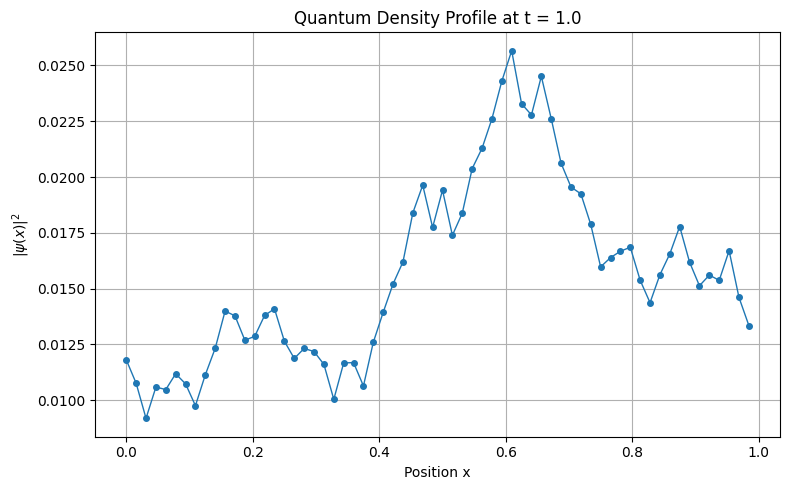

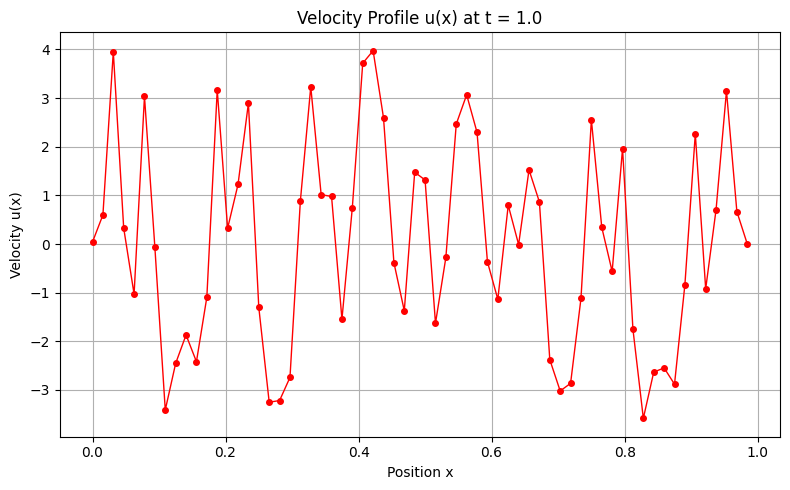

Min velocity u: -3.5827
Max velocity u: 3.9736
Mean velocity u: 0.0548


In [9]:
import numpy as np
from math import ceil, log2
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import StatevectorSimulator # Changed to StatevectorSimulator
# try the “modern” import first…
try:
    from qiskit.circuit.library import DiagonalGate
# …fall back if you’re on an older Terra
except ImportError:
    from qiskit.circuit.library.generalized_gates import DiagonalGate
from qiskit.visualization import plot_histogram # Still useful for quick checks
import matplotlib.pyplot as plt # Import matplotlib for custom plotting

# 1. Problem parameters (those can be changed think them as constants)
N       = 64 # Number of discrete position states
n_q     = ceil(log2(N)) # Number of qubits required to represent N states
t_tot   = 1.0 # Total simulation time
r       = 100 # Number of Trotter steps (Trotterization depth)
dt      = t_tot / r # Time step for each Trotter slice
hbar    = 1.0 # Planck's constant (set to 1 as per problem note)

# --- Parameters for H_visc ---
delta_0 = 1.0   # As specified in the image: "Take δ0 = 1"
epsilon_0 = 0.1 # Placeholder value, adjust as needed


# 2. Precompute H_visc(x)
x_vals  = np.linspace(0, 1, N, endpoint=False) # x_vals represent the discrete positions from 0 to 1 (exclusive of 1)
dx      = x_vals[1] - x_vals[0] # Spatial step size, needed for k_vals

k_vals_quantum = 2 * np.pi * np.fft.fftfreq(N, d=dx)


H_visc_array = np.zeros(N)
for i, x_val in enumerate(x_vals):
    # Term 1: ε0^4 π^2 sin^2(πx) cos^2(πx)
    term1_H_visc = (epsilon_0**4 * np.pi**2 * (np.sin(np.pi * x_val))**2 * (np.cos(np.pi * x_val))**2)
    
    # Base for Term 2: (ε0 cos(x) sin(πx) - ε0 π sin(x) * cos(πx))
    base_term2_H_visc = (epsilon_0 * np.cos(x_val) * np.sin(np.pi * x_val) -
                         epsilon_0 * np.pi * np.sin(x_val) * np.cos(np.pi * x_val))
    term2_H_visc = base_term2_H_visc**2
    
    # Base for Term 3: (ε0 sin(x) sin(πx) + ε0 π cos(x) * cos(πx))
    base_term3_H_visc = (epsilon_0 * np.sin(x_val) * np.sin(np.pi * x_val) +
                         epsilon_0 * np.pi * np.cos(x_val) * np.cos(np.pi * x_val))
    term3_H_visc = base_term3_H_visc**2
    
    H_visc_array[i] = - (hbar**2 / (2 * delta_0**2)) * (term1_H_visc + term2_H_visc + term3_H_visc)



# 3. Build QFT & inverse-QFT circuits
# QFT and inv_qft are QuantumCircuit objects themselves after decompose()
qft     = QFT(n_q, do_swaps=True).decompose()
inv_qft = qft.inverse() # Inverse QFT to switch back

def add_kinetic_step(qc: QuantumCircuit):

    # Use qc.compose() to insert the QFT circuit's individual gates into qc
    qc.compose(qft, qubits=range(n_q), inplace=True) # Apply QFT to move to momentum basis
    
    # Calculate the complex phases for each computational basis state |k> (momentum state)
    kinetic_phases = []
    for k_idx in range(2**n_q): # k_idx is the integer index of the basis state
        # Use the precomputed physical momentum value corresponding to this index
        p_k = k_vals_quantum[k_idx] # Corrected: Use physical momentum value
        phi_k = (hbar**2 * p_k**2 / 2) * dt / hbar 
        kinetic_phases.append(np.exp(-1j * phi_k)) # Calculate e^(-i * phi_k)
    


    # Apply the diagonal gate using DiagonalGate from qiskit.circuit.library
    qc.append(DiagonalGate(kinetic_phases), range(n_q))
    
    # Use qc.compose() to insert the inverse QFT circuit's individual gates into qc
    qc.compose(inv_qft, qubits=range(n_q), inplace=True) # Apply inverse QFT to move back to position basis

def add_H_visc_step(qc: QuantumCircuit):
 
    H_visc_phases = []
    for x_idx in range(N):
        # The H_visc energy is directly H_visc_array[x_idx]
        # The angle for time evolution is H_visc(x) * dt / hbar
        angle_H_visc = H_visc_array[x_idx] * dt / hbar # Corrected: Divide by hbar
        H_visc_phases.append(np.exp(-1j * angle_H_visc))
    

    # Apply the diagonal gate using DiagonalGate from qiskit.circuit.library
    qc.append(DiagonalGate(H_visc_phases), range(n_q))


# 4. Build the main Trotter circuit
qc = QuantumCircuit(n_q, n_q)


epsilon_0_initial = 0.01 # Renamed to avoid clash with H_visc epsilon_0

initial_state_amplitudes = np.zeros(N, dtype=complex)

for i in range(N):
    x_val = x_vals[i] # Get the continuous x value for this grid point

    if x_val <= 0.5:
        # Ψ(x, 0) = cos(x) + i sin(x) + j ε0 sin(πx)
        term1 = np.exp(1j * x_val) # Interpreting cos(x) + i sin(x) as e^(ix)
        term2 = 1j * epsilon_0_initial * np.sin(np.pi * x_val)
        initial_state_amplitudes[i] = term1 + term2
    else: # x_val > 0.5
        # Ψ(x, 0) = cos(0.5) + i sin(0.5) + j ε0 sin(0.5)
        constant_part = np.exp(1j * 0.5) # Interpreting cos(0.5) + i sin(0.5) as e^(i*0.5)
        term2_gt_0_5 = 1j * epsilon_0_initial * np.sin(0.5) # sin(0.5) is a constant here
        initial_state_amplitudes[i] = constant_part + term2_gt_0_5

# Normalize the initial state vector
norm = np.linalg.norm(initial_state_amplitudes)
if norm != 0:
    initial_state_amplitudes = initial_state_amplitudes / norm
else:
    print("Warning: Initial state amplitudes sum to zero. State will be all zeros.")

qc.initialize(initial_state_amplitudes, range(n_q))


# 4.2 Time evolution using Trotter steps
for _ in range(r):
    add_kinetic_step(qc)   # Applies gates that evolve the state due to kinetic energy
    add_H_visc_step(qc)    # Applies gates that evolve the state due to H_visc


# 5. Run on StatevectorSimulator to get the full wave function
backend_statevector = StatevectorSimulator()
qc_compiled = transpile(qc, backend_statevector) 
job_statevector = backend_statevector.run(qc_compiled) # Run the compiled circuit
result_statevector = job_statevector.result()
final_state_vector = np.asarray(result_statevector.get_statevector(qc_compiled)) 

print(f"Norm of final statevector: {np.linalg.norm(final_state_vector):.4f}")


dx = x_vals[1] - x_vals[0] # Spacing between x_vals

# Calculate numerical derivatives
dPsi_dx = np.gradient(final_state_vector, dx)
dPsi_conj_dx = np.gradient(final_state_vector.conj(), dx)

# Get Psi_bar
Psi_conj = final_state_vector.conj()

# Calculate the numerator
numerator = final_state_vector * dPsi_conj_dx - Psi_conj * dPsi_dx

# Calculate the denominator (which is |Psi|^2)
denominator = Psi_conj * final_state_vector

# Add a small epsilon to the denominator to avoid division by zero if |Psi|^2 is exactly zero
# This can happen at nodes of the wavefunction.
epsilon_denom = 1e-10 # A small number
denominator_safe = denominator + epsilon_denom * (denominator == 0) # Add epsilon only where denominator is zero

# Calculate u
u_complex = (1j * hbar / 2) * (numerator / denominator_safe)

u_velocity = np.real(u_complex)

# --- Plotting ---

# Plot 1: Probability Density |ψ(x)|^2 (same as before)
plt.figure(figsize=(8,5))
# Plotting the exact |psi(x)|^2 from StatevectorSimulator
plt.plot(x_vals, np.abs(final_state_vector)**2, marker='o', linestyle='-', markersize=4, linewidth=1)
plt.xlabel('Position x')
plt.ylabel(r'$|\psi(x)|^2$')
plt.title('Quantum Density Profile at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.savefig('quantum_density_profile.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Velocity u(x)
plt.figure(figsize=(8,5))
plt.plot(x_vals, u_velocity, marker='o', linestyle='-', markersize=4, linewidth=1, color='red')
plt.xlabel('Position x')
plt.ylabel('Velocity u(x)')
plt.title('Velocity Profile u(x) at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.savefig('velocity_profile_u.png', dpi=300, bbox_inches='tight')
plt.show()

# Optionally, print the range of u values
print(f"Min velocity u: {np.min(u_velocity):.4f}")
print(f"Max velocity u: {np.max(u_velocity):.4f}")
print(f"Mean velocity u: {np.mean(u_velocity):.4f}")


Norm of final classical statevector: 1.0000


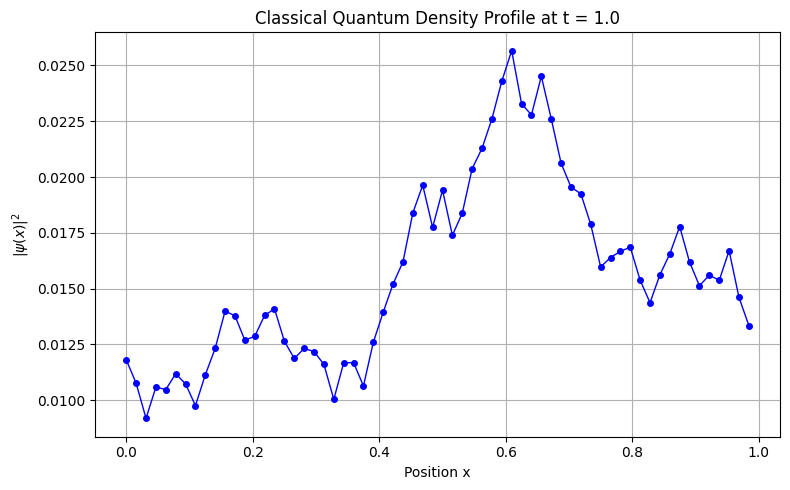

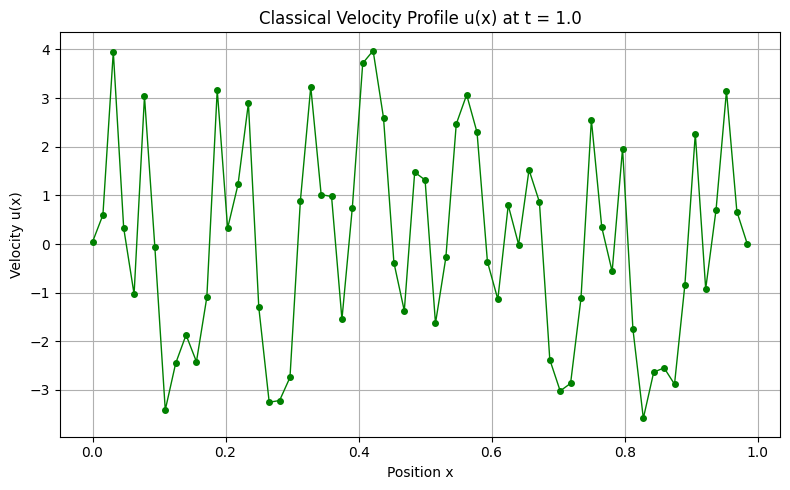

Classical Min velocity u: -3.5827
Classical Max velocity u: 3.9736
Classical Mean velocity u: 0.0548


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, log2

# 1. Problem parameters (matching the quantum simulation)
N       = 64 # Number of discrete position states
n_q     = ceil(log2(N)) # Number of qubits required (for consistency, not directly used in classical sim)
t_tot   = 1.0 # Total simulation time
r       = 100 # Number of time steps (analogous to Trotter depth)
dt      = t_tot / r # Time step for each iteration
hbar    = 1.0 # Planck's constant (set to 1.0)

# --- Parameters for H_visc (matching the quantum simulation) ---
delta_0 = 1.0   # As specified in the image: "Take δ0 = 1"
epsilon_0 = 0.1 # Placeholder value, adjust as needed


# 2. Precompute spatial grid and H_visc(x)
x_vals  = np.linspace(0, 1, N, endpoint=False) # x_vals represent the discrete positions
dx      = x_vals[1] - x_vals[0] # Spatial step size


H_visc_array = np.zeros(N)
for i, x_val in enumerate(x_vals):
    term1_H_visc = (epsilon_0**4 * np.pi**2 * (np.sin(np.pi * x_val))**2 * (np.cos(np.pi * x_val))**2)
    base_term2_H_visc = (epsilon_0 * np.cos(x_val) * np.sin(np.pi * x_val) -
                         epsilon_0 * np.pi * np.sin(x_val) * np.cos(np.pi * x_val))
    term2_H_visc = base_term2_H_visc**2
    base_term3_H_visc = (epsilon_0 * np.sin(x_val) * np.sin(np.pi * x_val) +
                         epsilon_0 * np.pi * np.cos(x_val) * np.cos(np.pi * x_val))
    term3_H_visc = base_term3_H_visc**2
    
    H_visc_array[i] = - (hbar**2 / (2 * delta_0**2)) * (term1_H_visc + term2_H_visc + term3_H_visc)
# --- End H_visc definition ---

# 3. Initial Wave Function (matching the quantum simulation)
epsilon_0_initial = 0.01 # Matching the quantum code's initial state parameter

initial_state_amplitudes = np.zeros(N, dtype=complex)
for i in range(N):
    x_val = x_vals[i]
    if x_val <= 0.5:
        term1 = np.exp(1j * x_val)
        term2 = 1j * epsilon_0_initial * np.sin(np.pi * x_val)
        initial_state_amplitudes[i] = term1 + term2
    else:
        constant_part = np.exp(1j * 0.5)
        term2_gt_0_5 = 1j * epsilon_0_initial * np.sin(0.5)
        initial_state_amplitudes[i] = constant_part + term2_gt_0_5

# Normalize the initial state vector
norm = np.linalg.norm(initial_state_amplitudes)
if norm != 0:
    psi_t = initial_state_amplitudes / norm
else:
    print("Warning: Initial state amplitudes sum to zero. Classical simulation will start with zeros.")
    psi_t = np.zeros(N, dtype=complex)



# 4. Define Operators for Split-Step Fourier Method
# Momentum space coordinates for FFT
k_vals = 2 * np.pi * np.fft.fftfreq(N, d=dx)

# Kinetic Energy Operator (in momentum space, diagonal)
# H_K = hbar^2 * k^2 / 2m. Assuming m=1 for consistency with typical quantum sim units.
# The exponent is -i * H_K * dt / hbar
kinetic_operator_phases = np.exp(-1j * (hbar**2 * k_vals**2 / 2) * dt / hbar) # Corrected: Divide by hbar

# Potential Energy Operator (in position space, diagonal)
# H_V = H_visc(x). The exponent is -i * H_V * dt / hbar
potential_operator_phases = np.exp(-1j * H_visc_array * dt / hbar) # Corrected: Divide by hbar


# 5. Time Propagation using First-Order Split-Step Fourier Method
for step in range(r):
    # 1. Apply Kinetic Evolution (in momentum space)
    psi_k = np.fft.fft(psi_t) # Transform to momentum space
    psi_k_evolved = psi_k * kinetic_operator_phases # Apply kinetic energy operator
    psi_t = np.fft.ifft(psi_k_evolved) # Transform back to position space

    # 2. Apply Potential (H_visc) Evolution (in position space)
    psi_t = psi_t * potential_operator_phases # Apply potential energy operator


# Final state vector after total time t_tot
final_state_vector_classical = psi_t

# Verify the norm of the final statevector (should be 1.0)
print(f"Norm of final classical statevector: {np.linalg.norm(final_state_vector_classical):.4f}")


dPsi_dx_classical = np.gradient(final_state_vector_classical, dx)
dPsi_conj_dx_classical = np.gradient(final_state_vector_classical.conj(), dx)

Psi_conj_classical = final_state_vector_classical.conj()

numerator_classical = final_state_vector_classical * dPsi_conj_dx_classical - Psi_conj_classical * dPsi_dx_classical
denominator_classical = Psi_conj_classical * final_state_vector_classical

epsilon_denom = 1e-10 # A small number
denominator_safe_classical = denominator_classical + epsilon_denom * (denominator_classical == 0)

u_complex_classical = (1j * hbar / 2) * (numerator_classical / denominator_safe_classical)
u_velocity_classical = np.real(u_complex_classical)

# --- Plotting ---

# Plot 1: Probability Density |ψ(x)|^2
plt.figure(figsize=(8,5))
plt.plot(x_vals, np.abs(final_state_vector_classical)**2, marker='o', linestyle='-', markersize=4, linewidth=1, color='blue')
plt.xlabel('Position x')
plt.ylabel(r'$|\psi(x)|^2$')
plt.title('Classical Quantum Density Profile at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.savefig('classical_quantum_density_profile.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Velocity u(x)
plt.figure(figsize=(8,5))
plt.plot(x_vals, u_velocity_classical, marker='o', linestyle='-', markersize=4, linewidth=1, color='green')
plt.xlabel('Position x')
plt.ylabel('Velocity u(x)')
plt.title('Classical Velocity Profile u(x) at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.savefig('classical_velocity_profile_u.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Classical Min velocity u: {np.min(u_velocity_classical):.4f}")
print(f"Classical Max velocity u: {np.max(u_velocity_classical):.4f}")
print(f"Classical Mean velocity u: {np.mean(u_velocity_classical):.4f}")
